# Is it possible to determine white wine quality based on its attributes?

## Introduction:

An alcoholic drink made from fermenting grapes or other fruits, wine has many attributes, including:

- fixed acidity (g(tartaric acid)/dm^3)
- volatile acidity (g(acetic acid)/dm^3)
- citric acid (g/dm^3)
- residual sugar (g/dm^3)
- chlorides (g(sodium chloride)/dm^3)
- free sulfur dioxide (mg/dm^3)
- total sulfur dioxide (mg/dm^3)
- density (g/cm^3)
- pH
- sulphates (g(potassium sulphate)/dm^3)
- alcohol (vol.%)

Quality, which is typically determined by professional wine tasters, could be affected by these attributes of wine. The goal of our project is to answer the following question: is it possible to determine white wine quality based on its attributes?

To answer this question, we will be using the Wine Quality dataset from the UC Irvine Machine Learning Repository which can be accessed [here](https://archive.ics.uci.edu/ml/datasets/Wine+Quality). There are two datasets to choose from: red wine and white wine. We chose the white wine dataset since it has more observations than the red wine dataset. The dataset includes the attributes listed above and a quality rating from 0 to 10 for each wine.

## Preliminary exploratory data analysis:

### Loading, Cleaning, and Wrangling

In [111]:
# Loading libraries required for notebook

library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 11)

After loading required libraries, we can load, clean, and tidy the dataset. The dataset is read from the internet using R, the quality column is converted to a factor, and the spaces are removed from the column names in the first code block.

In [112]:
wine_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", 
                        delim = ";") |>
    mutate(quality = as.factor(quality))

colnames(wine_data) <- make.names(colnames(wine_data))

wine_data

Rows: 4898 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (12): fixed acidity, volatile acidity, citric acid, residual sugar, chlo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6
6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6
8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.2,0.21,0.29,1.6,0.039,24,92,0.99114,3.27,0.50,11.2,6
6.6,0.32,0.36,8.0,0.047,57,168,0.99490,3.15,0.46,9.6,5


There are no missing or N/A values in our dataset.

In [113]:
cat("Number of missing values:", sum(is.na(wine_data)))

Number of missing values: 0

We set the seed so that ```initial_split``` always produces the same result, and split the data such that 90% of the data is for training, while 10% is for testing.

In [114]:
set.seed(1234) # Setting seed for reproducibility

wine_split <- initial_split(wine_data, prop = 0.90, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split) 

### Tables

The first table shows the number of observations for each class using ```group_by``` and ```summarize```, and the second table shows the mean, median, minimum, and maximum values for each predictor of the training dataset.

In [115]:
observation_counts <- wine_train |>
    group_by(quality) |>
    summarize(count = n())

observation_counts

pred_means <- wine_train |>
    select(-quality) |>
    pivot_longer(cols = fixed.acidity:alcohol, names_to = "key", values_to = "value") |> 
    group_by(key) |>
    summarize(mean = mean(value), median = median(value), min = min(value), max = max(value))

pred_means

quality,count
<fct>,<int>
3,17
4,145
5,1313
6,1981
7,790
8,157
9,4


key,mean,median,min,max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
alcohol,10.51013085,10.4000,8.00000,14.20000
chlorides,0.04592308,0.0430,0.00900,0.34600
citric.acid,0.33446789,0.3200,0.00000,1.66000
density,0.99404564,0.9938,0.98711,1.03898
fixed.acidity,6.85347175,6.8000,3.80000,14.20000
free.sulfur.dioxide,35.27274790,34.0000,2.00000,289.00000
pH,3.18805990,3.1800,2.72000,3.82000
residual.sugar,6.42505106,5.2000,0.60000,65.80000
sulphates,0.48919673,0.4700,0.22000,1.08000


### Visualizations

The distribution of the number of observations for each class is skewed slightly to the left, and a quality score of 6 was the most common. The quality range is from 3 to 9, rather than from 0 to 10.

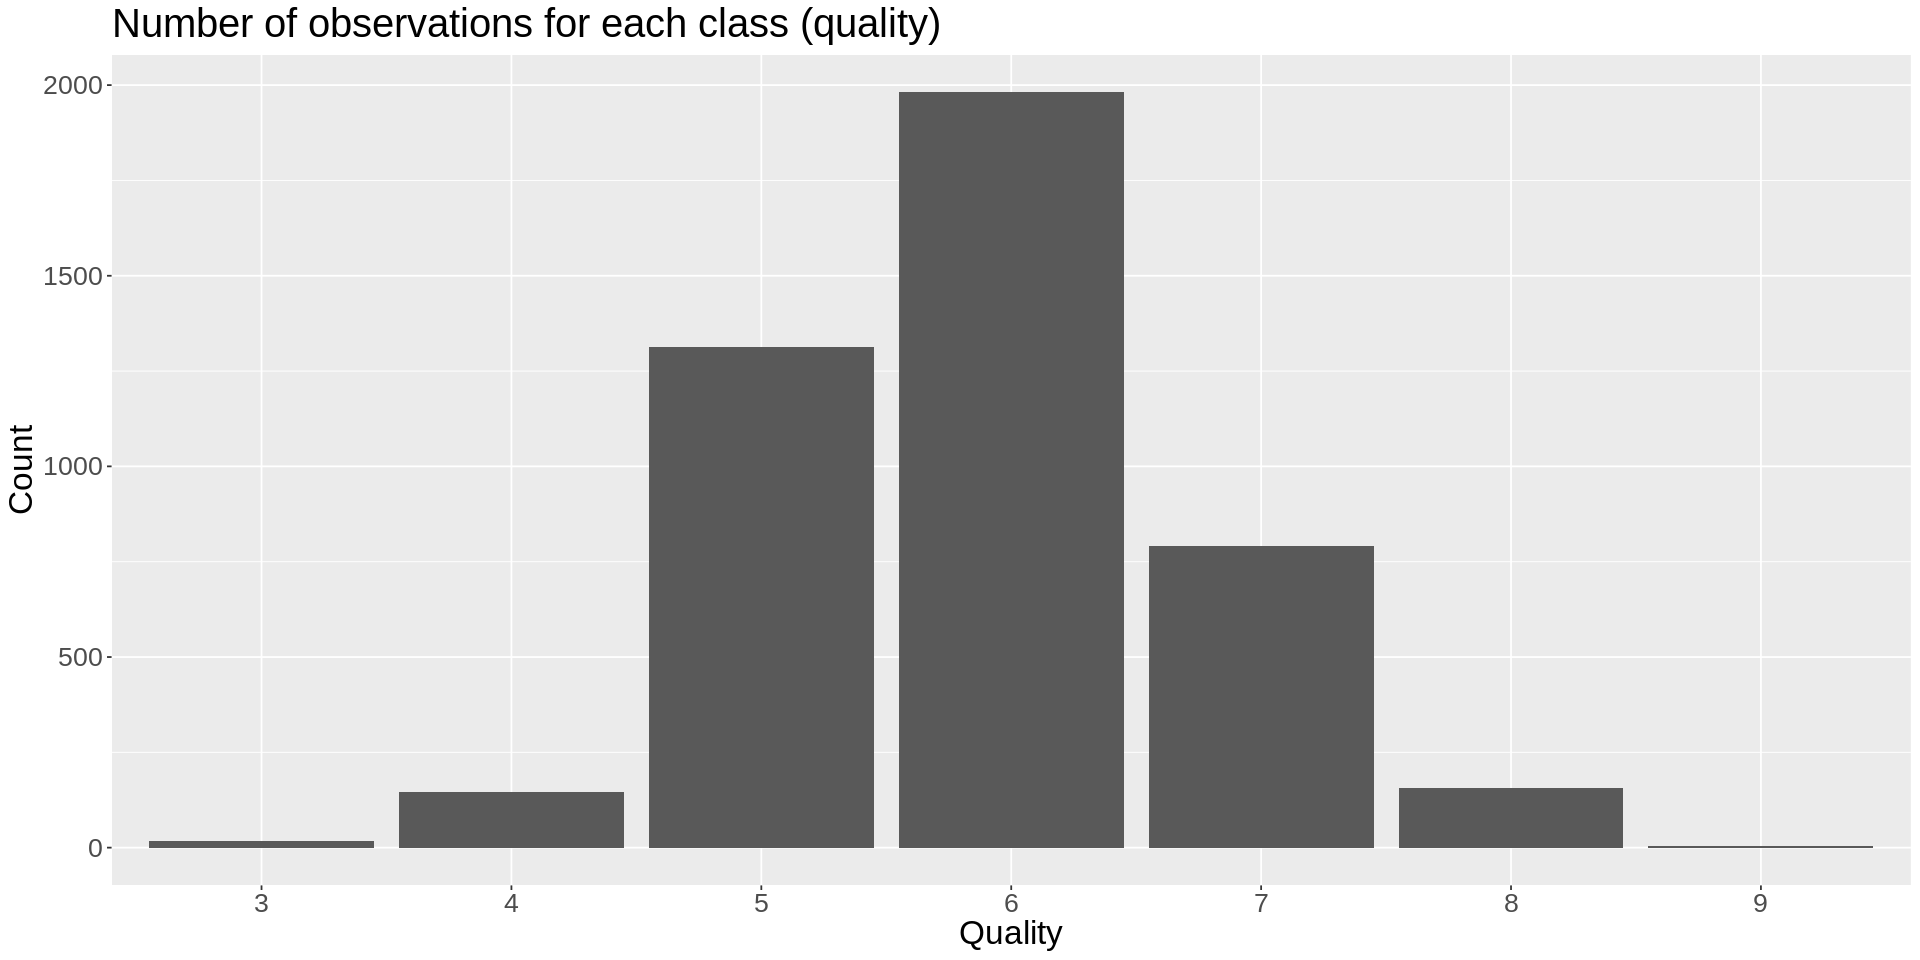

In [116]:
observation_plot <- wine_train |>
    ggplot(aes(x = quality)) +
    geom_bar() +
    theme(text = element_text(size = 20)) + 
    ggtitle("Number of observations for each class (quality)") +
    labs(x = "Quality", y = "Count")

observation_plot

After plotting the distributions of each predictor variable, we see that some variables have narrow distributions (chlorides, citric acid), some variables have broad distributions (pH, sulphates), and one variable is spread out (alcohol).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



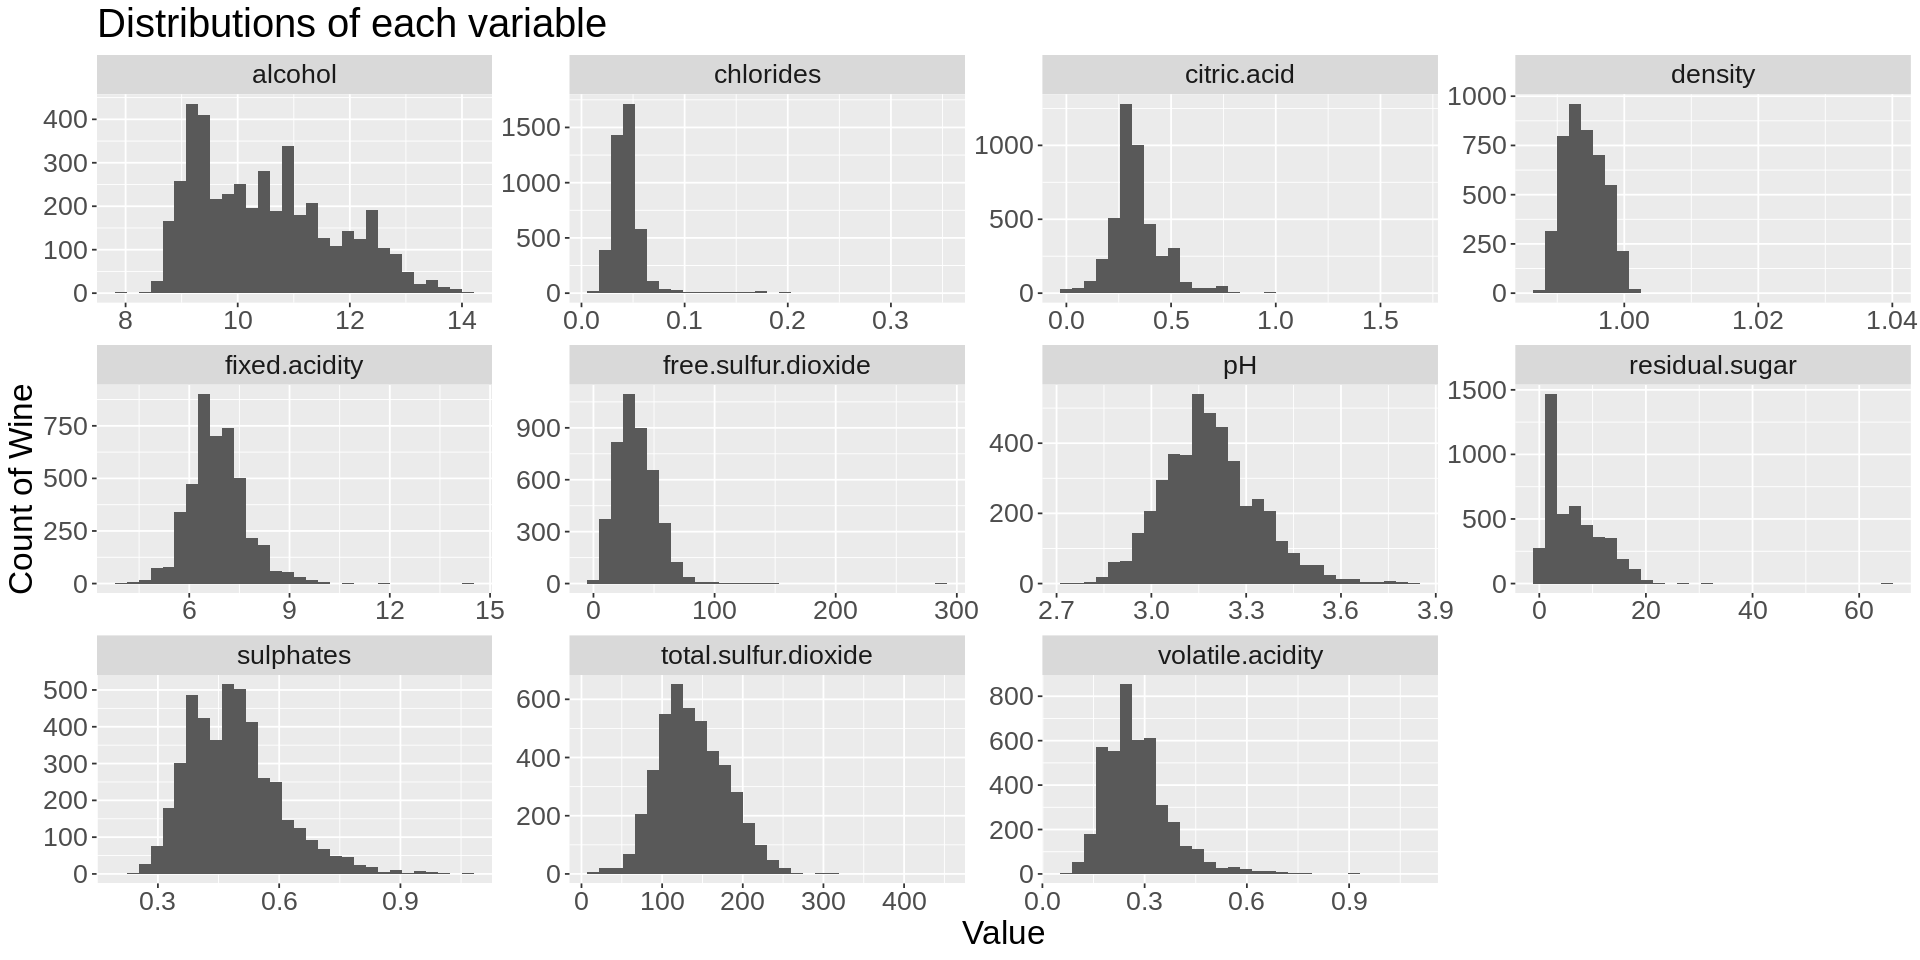

In [117]:
options(repr.plot.width = 16, repr.plot.height = 8)

pred_dist <- wine_train |>
    select(-quality) |>
    pivot_longer(cols = fixed.acidity:alcohol, names_to = "key", values_to = "value") |> 
    mutate(value = as.double(value)) |> 
    ggplot(aes(x = value)) + 
    geom_histogram() +
    facet_wrap(~ key, scales = "free") +
    theme(text = element_text(size = 20)) + 
    ggtitle("Distributions of each variable") +
    labs(x = "Value", y = "Count of Wine")

pred_dist

From the scatterplot below, there appears to be a weak but slightly positive relationship between alcohol content and quality.

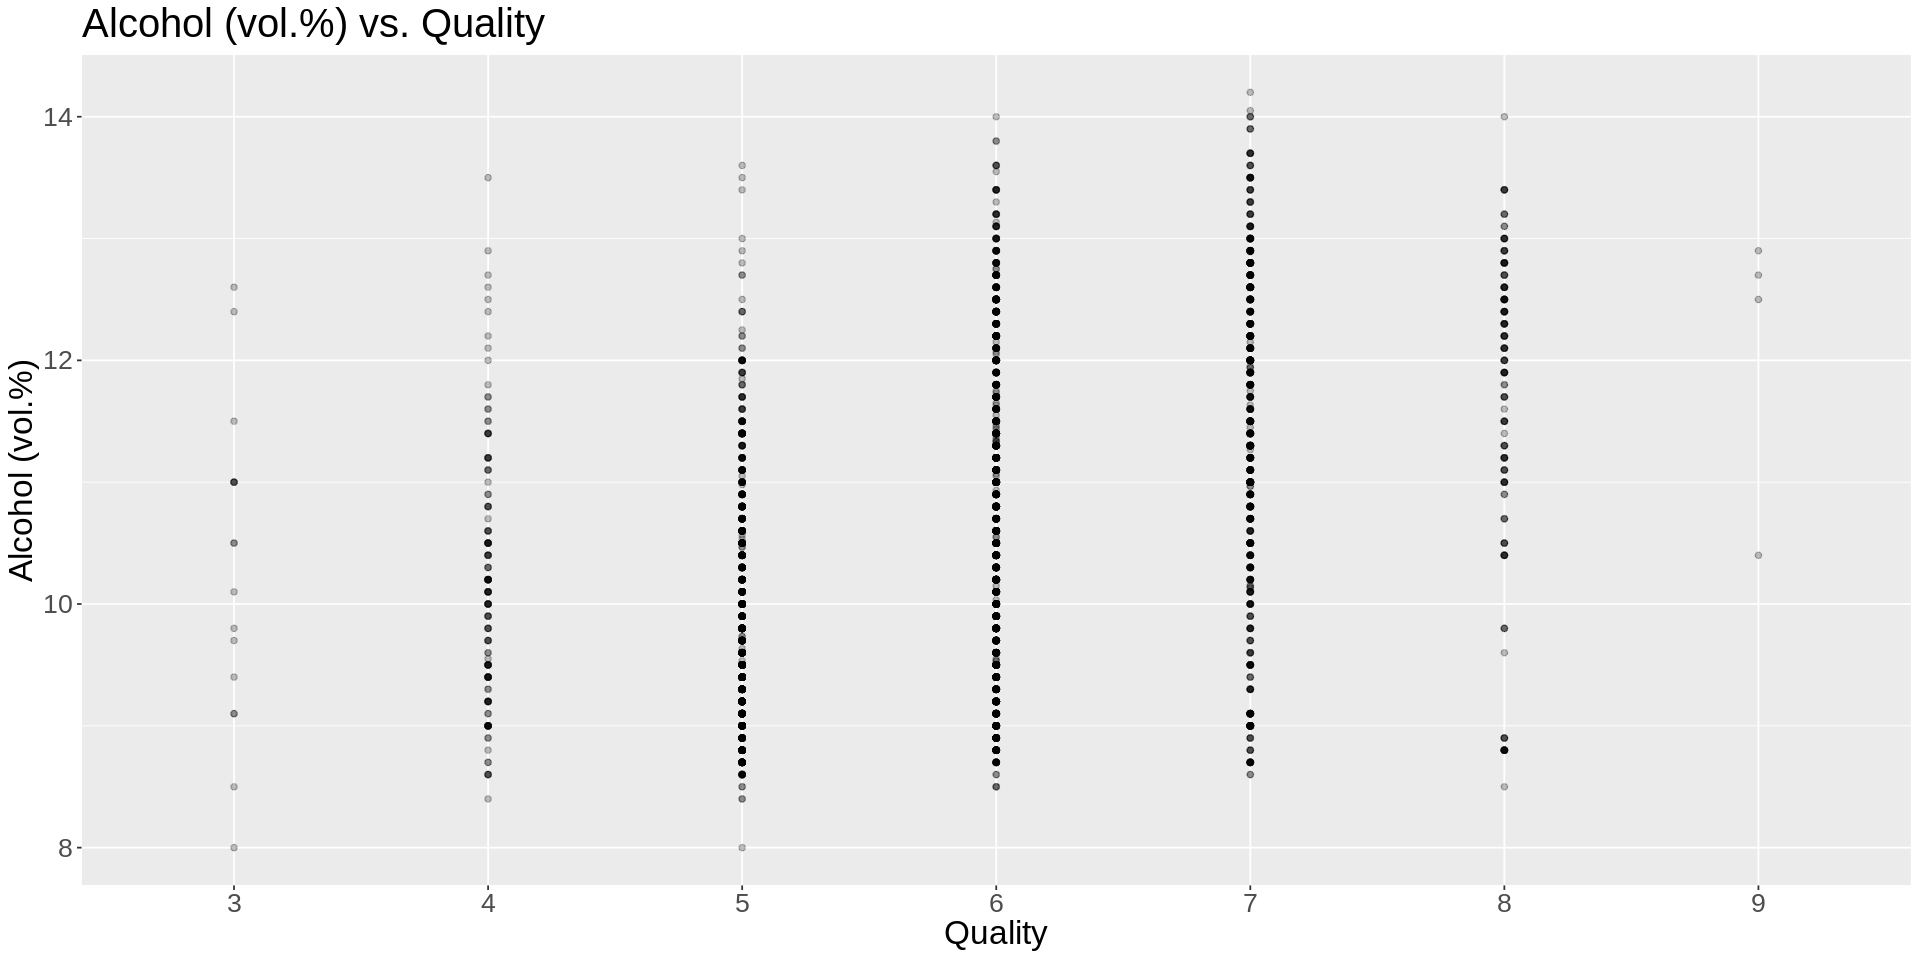

In [119]:
alcohol_vs_quality <- wine_train |>
    ggplot(aes(x = quality, y = alcohol)) + 
    geom_point(alpha = 0.25) +
    theme(text = element_text(size = 20)) + 
    ggtitle("Alcohol (vol.%) vs. Quality") +
    labs(x = "Quality", y = "Alcohol (vol.%)")

alcohol_vs_quality

## Methods:

- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results

- We will conduct data analysis by....
- The columns we will use for this project are fixed acidity, volatile acidity, residual sugars and alcohol as our predictors and quality as our target variable. 
- We will visualize the results in scatter and line plots?

## Expected outcomes and significance:

- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?